In [19]:
# import os
import json
import pathlib
import typing as tp
# from os.path import abspath, dirname, join

import cv2
import torch
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from dataset import (
    ImagePointsDataset,
    convert_targets_shape,
    show_face
)
from model import NeuralNetwork
# from detection import train_detector, detect


def read_csv(filename):
    res = {}
    with open(filename) as fhandle:
        next(fhandle)
        for line in fhandle:
            parts = line.rstrip('\n').split(',')
            coords = np.array([float(x) for x in parts[1:]], dtype='float64')
            res[parts[0]] = coords
    return res


data_dir = pathlib.Path("/home/david/study/shad/cv_fall_2022/lesson_6_nn_intro/public_tests/00_test_img_input")
output_dir = ""

train_dir = data_dir/'train'
test_dir = data_dir/'test'

train_gt: tp.Dict[str, np.ndarray] = read_csv(train_dir/'gt.csv')
train_img_dir = train_dir/'images'

# model = train_detector(train_gt, train_img_dir, fast_train=False)

# code_dir = dirname(abspath(__file__))
# model_filename = join(code_dir, 'facepoints_model.ckpt')
model_filename = './facepoints_model.ckpt'
test_img_dir = test_dir/'images'
# detected_points = detect(model_filename, test_img_dir)
# save_csv(detected_points, join(output_dir, 'output.csv'))

In [6]:
ds = ImagePointsDataset("train", 0.932, train_img_dir, train_gt)
len(ds)

5592

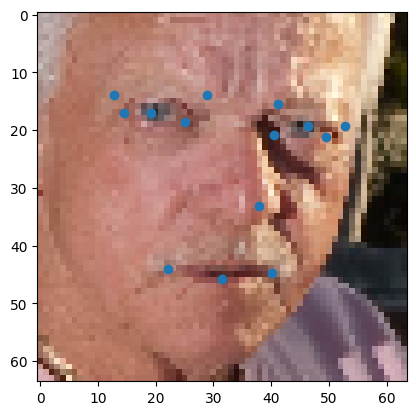

In [7]:
show_face(ds, 129)

In [8]:
with open('./configs/architectures/simple_cnn.json') as f:
    net_arch = json.load(f)

In [9]:
with open('./configs/learning_process/base.json') as f:
    learning_process = json.load(f)

In [10]:
dataset_params = learning_process["dataset_params"]

train_fraction = dataset_params["train_fraction"]

train_dataset = ImagePointsDataset(
    mode="train",
    train_fraction=train_fraction,
    data_dir=train_img_dir,
    train_gt=train_gt,
    new_size=dataset_params["new_size"]
)

val_dataset = ImagePointsDataset(
    mode="val",
    train_fraction=train_fraction,
    data_dir=train_img_dir,
    train_gt=train_gt,
    new_size=dataset_params["new_size"]
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size = dataset_params["train_batch_size"],
    shuffle=True
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size = dataset_params["val_batch_size"],
    shuffle=True
)

In [22]:
loss_params = learning_process["hyper_params"]["loss"]
optimizer_params = learning_process["hyper_params"]["optimizer"]
epoch_nums = learning_process["hyper_params"]["epoch_nums"]

net = NeuralNetwork(net_arch)
loss = getattr(torch.nn, loss_params["loss_type"])(**loss_params["params"])
optimizer = getattr(torch.optim, optimizer_params["optimizer_type"])(
    net.parameters(),
    **optimizer_params["params"]
)
optimizer.zero_grad()

best_val_loss = float("inf")

In [ ]:
# default `log_dir` is "runs".
writer = SummaryWriter()

for epoch in range(epoch_nums):
    print(f"{epoch=}:")

    loss_history = []
    for X, y, _ in train_dataloader:
        optimizer.zero_grad()
        y_pred = net(X)
        loss_value = loss(y_pred, y)
        loss_value.backward()
        optimizer.step()
        cur_train_loss = loss_value.cpu().data.item()
        loss_history.append(cur_train_loss)
        print("train_loss: %.4f" % cur_train_loss, end='\r')
                
    train_loss = np.mean(loss_history)
    print("train_loss:\t%.5f" % train_loss)

    loss_history = []
    for X, y, shape in val_dataloader:
        shape = shape.numpy()
        y_pred = net(X)
        loss_value = loss(y_pred, y) 
        loss_history.append(loss_value.cpu().data.item())
    val_loss = np.mean(loss_history)
    print("val_loss:\t%.5f" % val_loss)
    print("val_quality:\t%.5f" % (val_loss * 100**2))
    
    writer.add_scalars(
        'Loss', 
        {
            'train': train_loss,
            'val': val_loss,
        }
    )
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(
            {
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            },
            pathlib.Path("./facepoints_model.ckpt")
        )
        print("*")
        
    print()    

epoch=0:
train_loss:	0.03665
val_loss:	0.02668
val_quality:	266.76637
*

epoch=1:


In [13]:
%load_ext tensorboard

In [16]:
%tensorboard --logdir runs

In [456]:
net = NeuralNetwork()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

checkpoint = torch.load("./facepoints_model.ckpt")
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

NameError: name '__file__' is not defined

In [408]:
net(val_dataset[0][0].unsqueeze(0)),\
val_dataset[0][1]

(tensor([[0.2690, 0.2840, 0.4220, 0.2754, 0.5755, 0.2979, 0.7259, 0.3105, 0.3061,
          0.3598, 0.3619, 0.3624, 0.4086, 0.3520, 0.5807, 0.3439, 0.6322, 0.3450,
          0.7278, 0.3623, 0.4857, 0.5165, 0.3973, 0.6255, 0.4922, 0.6351, 0.6273,
          0.6611]], grad_fn=<SigmoidBackward0>),
 tensor([0.2222, 0.2407, 0.4074, 0.2407, 0.5926, 0.2222, 0.7222, 0.2037, 0.2593,
         0.2963, 0.2963, 0.2963, 0.3519, 0.2963, 0.6667, 0.2963, 0.7222, 0.2963,
         0.7593, 0.2963, 0.5556, 0.5556, 0.3148, 0.6667, 0.5000, 0.6852, 0.6481,
         0.6481]))

In [606]:
def train_detector(
        train_gt: tp.Dict[str, np.ndarray],
        train_img_dir: pathlib.PosixPath,
        fast_train: bool
) -> NeuralNetwork:
    
    # Create train and val Dataloaders.
    train_fraction = 0.9

    train_dataset = ImagePointsDataset(
        mode="train",
        train_fraction=train_fraction,
        data_dir=train_img_dir,
        train_gt=train_gt,
        new_size=(64, 64)
    )

    val_dataset = ImagePointsDataset(
        mode="val",
        train_fraction=train_fraction,
        data_dir=train_img_dir,
        train_gt=train_gt,
        new_size=(64, 64)
    )

    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size = 100,
        shuffle=True
    )

    val_dataloader = DataLoader(
        dataset=val_dataset,
        batch_size = 100,
        shuffle=True
    )

    # Init blank model and optimizer.
    net = NeuralNetwork()
    loss = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
    optimizer.zero_grad()

    epoch_nums = 1 if fast_train else 30
    best_val_loss = float("inf")
    
    # Process of training and validation.
    for epoch in range(epoch_nums):
        if not fast_train:
            print(f"{epoch=}:")

        loss_history = []
        for i, (X, y, _) in enumerate(train_dataloader):
            if fast_train and i > 20:
                break
            optimizer.zero_grad()
            y_pred = net(X)
            loss_value = loss(y_pred, y)
            loss_value.backward()
            optimizer.step()
            loss_history.append(loss_value.cpu().data.item())
            if not fast_train:
                print("train_loss: %.4f" % loss_value.cpu().data.item(), end='\r')

        train_loss = np.mean(loss_history)
        if not fast_train:
            print("train_loss:\t%.5f" % train_loss)

        loss_history = []
        for X, y, shape in val_dataloader:
            shape = shape.numpy()
            y_pred = net(X)
            loss_value = loss(y_pred, y) 
            loss_history.append(loss_value.cpu().data.item())
            if fast_train:
                break
        val_loss = np.mean(loss_history)
        if not fast_train:
            print("val_loss:\t%.5f" % val_loss)
            print("val_quality:\t%.5f" % (val_loss * 100**2))

        if not fast_train and val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(
                {
                    'model_state_dict': net.state_dict()
                },
                pathlib.Path("./facepoints_model.ckpt")
            )
            print("*")

        if not fast_train:
            print()
            
    # Load best one model.
    if not fast_train:
        net = NeuralNetwork()
        checkpoint = torch.load("./facepoints_model.ckpt")
        net.load_state_dict(checkpoint['model_state_dict'])       
            
    return net

In [ ]:
# detected_points = detect(model_filename, test_img_dir)
def detect(
        model_filename: str,
        test_img_dir: pathlib.PosixPath
) -> np.ndarray:
    net = NeuralNetwork()
    checkpoint = torch.load(model_filename)
    net.load_state_dict(checkpoint['model_state_dict'])

    train_dataset = ImagePointsDataset(
        mode="val",
        train_fraction=0.0,
        data_dir=test_img_dir,
        train_gt=None,
        new_size=(64, 64)
    )
    
    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size = 100,
        shuffle=True
    )    
    